
    
# DWI Workshop - Day 1 
## Diffusion Tensor Imaging (DTI)

Presented By: 

    
## I. Theory & Background 
###  Pulsed Gradient Spin Echo (Stejskal-Tanner, 1965) 
90 degree pulse followed by a 180 degree inversion pulse. Diffusion sensitizing gradients on either side of the inversion pulse. The first gradient will caused dephasing of the isochromat. For static or non-diffusing spins the second gradient will cause an equivalent amount of rephasing of the signal. However, for diffusing spins, there is a non-zero accumulation of phase, and hence signal attenuation. 

### Modeling of Diffusion 

This can be modeled accordingly: 

$$ \frac{S(TE, \gamma, G, \Delta, \delta)}{S(TE)} = e^{-{\gamma^2 G^2 \delta^2(\Delta - \delta/3)D}} $$

$$ b = \gamma^2 G^2 \delta^2(\Delta - \delta/3)D $$

$$ \frac{S(b)}{S_0} = e^{-bD} $$

Diffusion may be isotropic or anisotropic (e.g. in white matter and axon bundles). Diffusion tensor imaging (DTI) aims to model the change in diffusivity in different directions. Multiple diffusion directions in q-space are then modeled as a tensor. 


&emsp;&emsp;<img src="images/qspace.png" width="500"/>

<p align='center'>
&emsp; $$Q = \begin{bmatrix} \sigma_{xx} & \sigma_{xy} & \sigma_{xz} \\ 
                        \sigma_{yx} & \sigma_{yy} & \sigma_{yz} \\ 
                          \sigma_{zx} & \sigma_{zy} & \sigma_{zz} \end{bmatrix}$$

<img src="images/ellispoid.gif" width="200"/>
</p>


### DTI Metrics

Eigen decomposition then yields three prinicpal eigenvector ($ \vec{e_1}, \vec{e_2}, \vec{e_3} $) and eigenvalues ($ \lambda_1, \lambda_2, \lambda_3 $). 

Mean Diffusivity = $ (\lambda_1 + \lambda_2 + \lambda_3)/3 $

Radial Diffusivity = $ (\lambda_1 + \lambda_2)/2 $ 

Fractional Anisotropy = $ \sqrt{3/2}\frac{\sqrt{(\lambda_1 -\lambda_2)^2 + (\lambda_1 -\lambda_3)^2 + (\lambda_2 - \lambda_3)^2}}{\sqrt{\lambda_1^2 + \lambda_2^2 + \lambda_3^2}}$



In [17]:
import dipy as dipy
import numpy as np
from dipy.data import fetch_stanford_hardi 
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import nibabel as nib
import matplotlib.pyplot as plt
from dipy.segment.mask import median_otsu
import dipy.reconst.dti as dti
from dipy.reconst.dti import fractional_anisotropy, color_fa
from dipy.data import get_sphere
from dipy.viz import window, actor
from PIL import Image

In [2]:
sphere = get_sphere('repulsion724')

In [3]:
# Dataset with high angular resolution diffusion weighted imaging - https://purl.stanford.edu/ng782rw8378
# Uncomment to download data

# data = fetch_stanford_hardi()

In [4]:
fbval = 'stanford_hardi/HARDI150.bval'
fbvec = 'stanford_hardi/HARDI150.bvec'
fdwi = 'stanford_hardi/HARDI150.nii.gz'

bval, bvec = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bval,bvec)
print(gtab.info)

B-values shape (160,)
         min 0.000000
         max 2000.000000
B-vectors shape (160, 3)
          min -0.999130
          max 0.998710

None


In [5]:
data = nib.load(fdwi).get_fdata()
print(data.shape)

(81, 106, 76, 160)


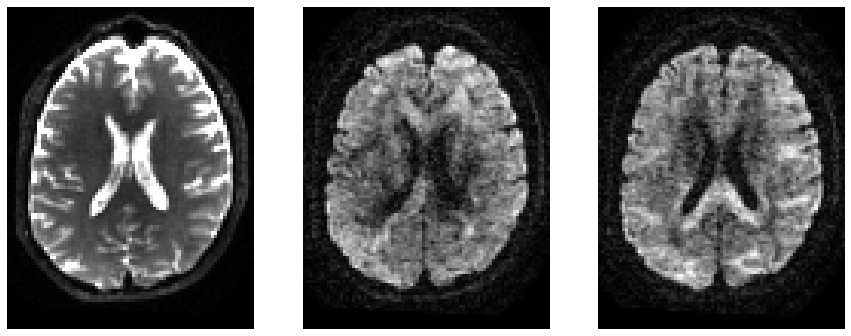

In [6]:
slice=40

plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(np.flipud(data[:,:,slice, 0].T), cmap='gray'), plt.axis('off'), plt.clim(0,2e3)
plt.subplot(132), plt.imshow(np.flipud(data[:,:,slice, 50].T), cmap='gray'), plt.axis('off')
plt.subplot(133), plt.imshow(np.flipud(data[:,:,slice, 100].T), cmap='gray'), plt.axis('off')
plt.show()

First we will need to perform brain segmentation before we can fit our tensor model.

In [8]:
maskdata, mask = median_otsu(data,vol_idx=range(10,50), median_radius=4, numpass=2,autocrop=True, dilate=3)
print(maskdata.shape)

(73, 88, 62, 160)


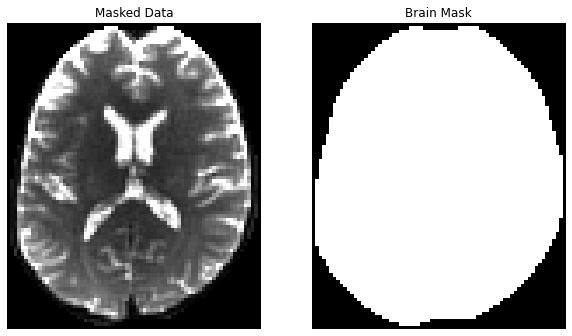

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.rot90(maskdata[:,:,30,0]), cmap='gray'), plt.axis('off'), plt.clim(0,2e3), plt.title('Masked Data')
plt.subplot(122)
plt.imshow(np.rot90(mask[:,:,30]), cmap='gray'), plt.axis('off'), plt.title('Brain Mask')
plt.show()

In [11]:
# Fit DTI Model 

dtimodel = dti.TensorModel(gtab)
dtifit = dtimodel.fit(maskdata)

The Fit model contains our fitted parameters, such as the eigenvalues and eigenvectors ,from which we can determine parameters of interest, such as the fractional anisotropy. 

In [12]:
FA = dti.fractional_anisotropy(dtifit.evals)
FA[np.isnan(FA)] = 0
FA = np.clip(FA,0,1)
RGB = dti.color_fa(FA, dtifit.evecs)

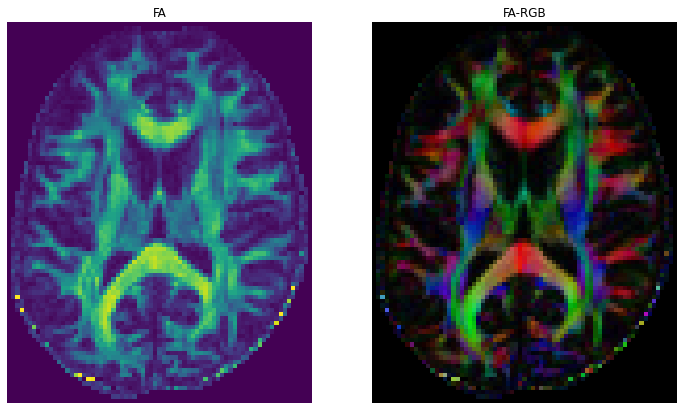

In [13]:
plt.figure(figsize=(12,7))
plt.subplot(121)
plt.imshow(np.rot90(FA[:,:,30]),aspect='auto'), plt.axis('off'), plt.title('FA')
plt.subplot(122)
plt.imshow(np.rot90(RGB[:,:,30]),aspect='auto'), plt.axis('off'), plt.title('FA-RGB')
plt.show()

In [14]:
# Visualizing ODFs
ODFs = dtimodel.fit(data[20:50,  55:85, 38:39]).odf(sphere)

In [16]:
scene = window.Scene()
odfactor = actor.odf_slicer(ODFs, sphere=sphere, scale=0.5, colormap=None)
scene.add(odfactor)
window.record(scene,n_frames=1, out_path='images/tensor_odfs.png', size=(600,600))

(<matplotlib.image.AxesImage at 0x7f9698c40370>, (-0.5, 599.5, 599.5, -0.5))

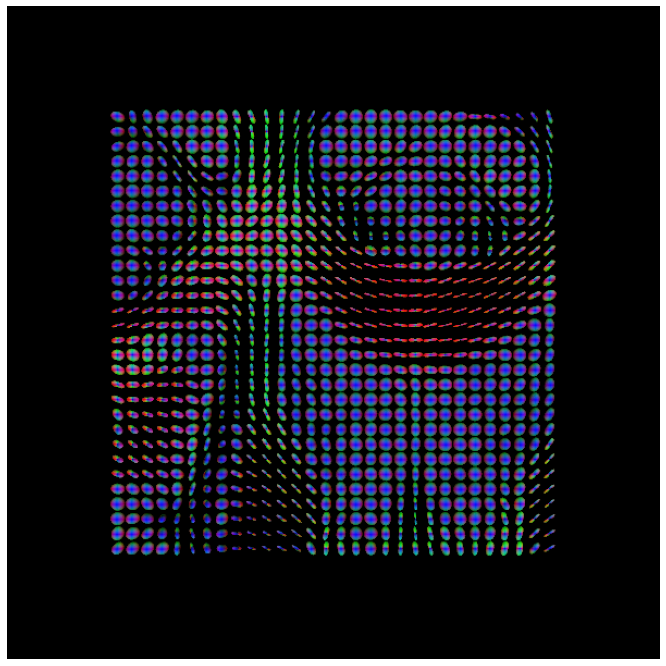

In [23]:
tmp = Image.open('images/tensor_odfs.png')
plt.figure(figsize=(12,12))
plt.imshow(tmp), plt.axis('off')